### NetCDF data file management  
This notebook is beginner-friendly and suitable for a range of use cases in modeling data preparation 
#### This notebook aims following tasks 🥅
- [ ] reading the NetCDF file
- [ ] extracting attributes
- [ ] extracting physical values as arrays
- [ ] display as images
- [ ] display in automatically adjusting frames
- [ ] extract by data range / give area AOI (shapefile)
- [ ] save png images / create gif animations
- [ ] convert into geotiff, so that work easilly with rasterio/GDAL/QGIS/ENVI

This notebook contains functionality for extracting data from NetCDF files for an area of interest (AOI) and converting them to the text data format for use by grid-based ecosystem models.   
Use case scenario;  Boreal Ecosystem Productivity Simulator uses grid-based bin data sets as input weather data files. This code will create data set for a given resolution to match the spatial resolution of the satellite sensor
✔️  

Readings  

[NOAA](https://www.weather.gov/abrfc/map) - learn precipitation measurement techniques  
[NASA](https://www.giss.nasa.gov/tools/panoply/) Panoply netCDF, HDF, and GRIB Data Viewer



In [14]:
# imports for arrays
import numpy as np
import xarray as xr
import rioxarray as rio
# imports for dataframes
import pandas as pd
import geopandas as gpd
# imports for image data management
import rasterio as ras
import imageio 
from scipy import ndimage
from rasterio.enums import Resampling as resa
# imports for data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from turtle import color
# import os related
import os
import sys
import glob

# uncomment if need to print complete numpy array
#np.set_printoptions(threshold=sys.maxsize)

In [2]:

# fucnction casting a point to nearest actually available point coordinates
def find_nearest_coord(coord_array, coord):
    """
    This function search for the nearest lat from
    a netcdf lat array.
    input: netcdf lat array, lat in mind
    output: nearest  lat
    useage: in this way we can copy the data value nearest to our location
    from the raster, unless xarray raise errors
    """
    idx = np.abs(coord_array - coord).argmin()
    return coord_array[idx]

# function for determining number of image rows to feed in  matplotlib gridspec
def find_number_of_rows(number_of_days, image_per_row):
    '''
    This function take number of days(number of images) and
    images per row as input.
    It calculates number of rows needed to plot all images
    '''
    # number of rows
    number_of_rows = number_of_days//image_per_row
    # image remained for notfull row
    remained_images = number_of_days % image_per_row
    # condition check for remain images
    if remained_images == 0:
        return number_of_rows
    else:
        return number_of_rows + 1


# determine the grid postion for matplotlib image grid
def find_position_inrow(image_no, images_per_row):
    '''
    determin the postion in a image row
    '''
    extra_images = image_no % images_per_row
    if image_no < 4:
        return image_no - 1
    elif extra_images == 0:
        return 3
    else:
        return extra_images-1

### Extract Data (Precipitation) - Using AOI and date range ⌚
use this code cell to extract data for a given area for a give day range.  
User input 
:sunglasses:
- [ ] AOI shape file  
- [ ] Day range

In [3]:
# read nc data set
fn = './input/pr_2021.nc'
# open data set
pr_data = xr.open_dataset(fn)
# print attributes
#print(pr_data)

# aoi for data extraction:: arrange lat and lon lists
aoi = gpd.read_file('./input/cut_shape/aoi_ohio.shp')
#print(aoi.total_bounds)
# min max lat
aoi_lat = [aoi.total_bounds[1], aoi.total_bounds[3]]
# min max lon
aoi_lon = [aoi.total_bounds[0], aoi.total_bounds[2]]
print(aoi_lat, aoi_lon)

# day range for selecting data
start_day = '2021-01-01'
end_day = '2021-12-31'

# selecting data for day range and AOI
precep_amount = pr_data["precipitation_amount"].sel(
                                            day=slice(start_day, end_day),
                                            lat=slice(aoi_lat[1], aoi_lat[0]),
                                            lon=slice(aoi_lon[0], aoi_lon[1])
                                            )
precep_amount

[41.232460670068676, 42.20102472277138] [-84.4134413603948, -83.47524192774395]


<xarray.DataArray 'precipitation_amount' (day: 365, lat: 24, lon: 22)>
[192720 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -84.39 -84.35 -84.31 -84.27 ... -83.6 -83.56 -83.52
  * lat      (lat) float64 42.19 42.15 42.11 42.07 ... 41.36 41.32 41.28 41.23
  * day      (day) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    coordinates:        lon lat time

#### 🚄 Draw a quick plot of a given day

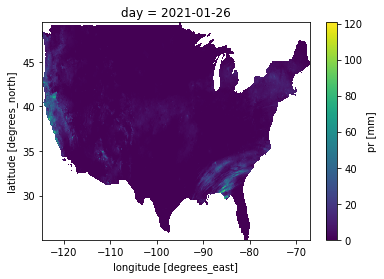

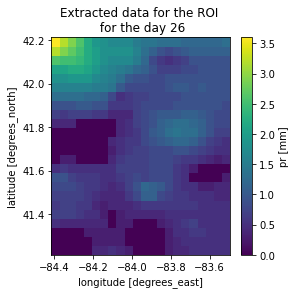

In [7]:
# quick plot of  precep raster for a given day
# user in put:: give any number between 0-365
day = 25
# use input ends

# plot for USA
pr_data["precipitation_amount"][day].plot()
plt.show()
# plot for extrated data for ROI
fig, (ax1) = plt.subplots(figsize=(4,4))
precep_amount[day].plot()
plt.title('Extracted data for the ROI \n for the day {}'.format(day+1))
plt.show()


##### Drawing histogram 
This cell contains functionality for creating bins and frquencies for a daily data array. It will plot histogram for a day range.

dimentions of the data set are (365, 24, 22)
(365, 24, 22)
Max for the array is 101.4000015258789
frequencies are [151969  13887   7786   4659   3552   2301   1792   1198   1019]
bins area [ 0  3  6  9 12 15 18 21 24 27]


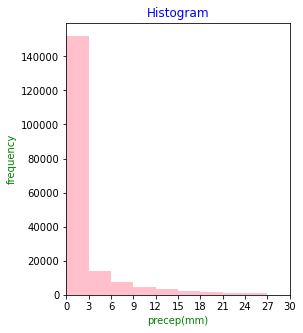

In [38]:
print('dimentions of the data set are {}'.format(precep_amount.shape))
print(precep_amount.shape)
# flat the array for given time range to build a histogram elements
precep_flat = precep_amount.values.flatten()
print('Max for the array is {}'.format(precep_flat.max()))
# create bins
bin_list = list(np.arange(0,30,3))
# display histogram by values
hist, bins = np.histogram(precep_flat, bins=bin_list)
print('frequencies are {val1}\nbins area {val2}'.format(val1=hist, val2= bins))

# ploting histo
fig, (ax1) = plt.subplots(figsize=(4,5))
# creating histo plot
plt.hist(precep_flat, bins=bin_list, histtype='bar', color='pink')
# add tiitle
plt.title('Histogram', color='blue')
#  add xy lables
plt.xlabel("precep(mm)", color='green')
plt.ylabel("frequency", color='green')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax1.set_xlim(0,30)
# show plot
plt.show()

##### Draw an image after resampling the array

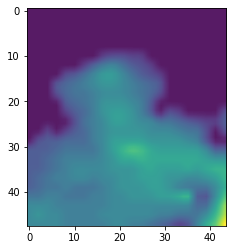

In [46]:
# print precep amout array for a day:: day 20 no precep
#print(precep_amount[20].values)
# scipy ndimage to resample the array
precep_resampled = ndimage.zoom(precep_amount[31], 2, order=1)
# draw a single smooth image
im2 = plt.imshow(precep_resampled,
                 cmap=plt.cm.viridis,
                 alpha=.9,
                 interpolation='bilinear',
                 #extent=extent
                )
plt.show()

#### Visualize images and save png for any number of days within a year
user input alert ⚠️ <mark> change the dayno accordingly </mark>.

2021-01-01


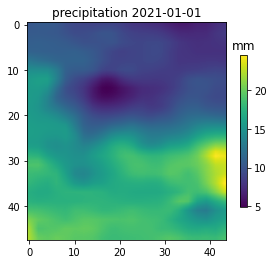

2021-01-02


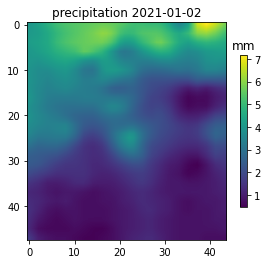

2021-01-03


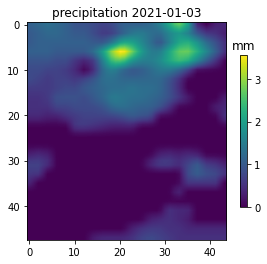

2021-01-04


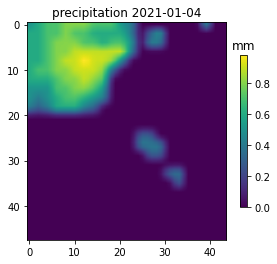

2021-01-05


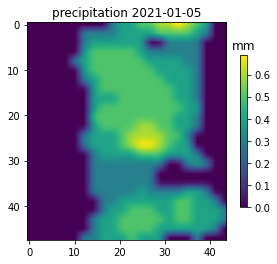

In [8]:
# user input
dayno = 5
# draw images for all days
for day in range(dayno):  #len(precep['day'])
    # take out the current day 
    real_day = str(precep_amount['day'].values[day])
    print(real_day[:-19])
    # slice the array
    day_array = precep_amount[day]
    # resample array to smooth the appearnce nearest = 0 bilinear = 1 cubic = 3
    day_resampled = ndimage.zoom(day_array, 2, order=1)
    #print(day_resampled)
    # plot as image
    rain = plt.imshow(day_resampled,
                     cmap=plt.cm.viridis,
                     interpolation='bilinear'
                     )
    # give tittle
    plt.title('precipitation'+' '+real_day[:-19])
    # give color bar
    clb = plt.colorbar(shrink=0.7, pad=0.04)
    clb.ax.set_title('mm')
    # plot
    plt.show()

##### Use the following cell to visualize images as a grid. It may be helpful in a quick overview of the data  
<mark>user inputs</mark>
- [ ] dayno - number of days you need plots
- [ ] imge_in_row - number of images in a single row (user can define)

(15, 8)
GridSpec(2, 4)


<Figure size 1080x576 with 0 Axes>

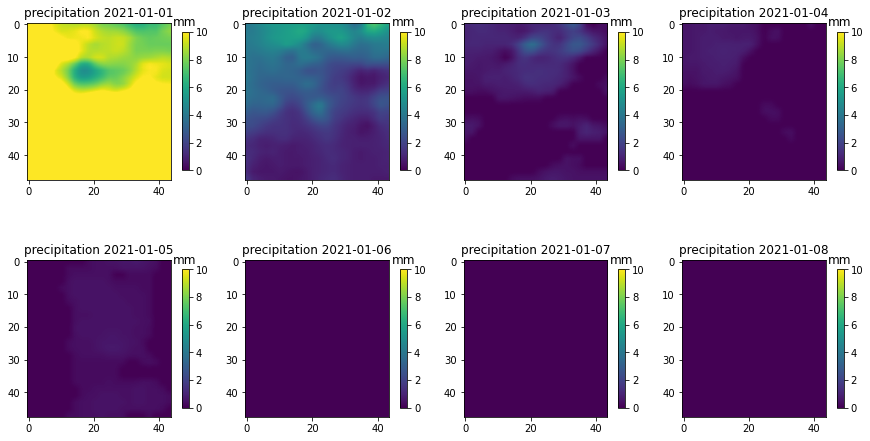

In [11]:
# user input
dayno = 8 # len(precep['day'])
imge_in_row = 4 #3
# user input ends

# size of tuples::15 you may change this 
figsize_tup = (15, find_number_of_rows(dayno, imge_in_row)*4)
print(figsize_tup)
# plt figure
fig = plt.figure(figsize=figsize_tup)
# set the grid
gs = GridSpec(find_number_of_rows(dayno, imge_in_row), imge_in_row, figure=fig)
print(gs)
# draw images in the grid
# figure declaration must go in same cell as plotting
fig = plt.figure(figsize=figsize_tup)
# set the grid
gs = GridSpec(find_number_of_rows(dayno, imge_in_row), imge_in_row, figure=fig)
for im in range(dayno):
    ax_lab = 'ax'+str(im)
    rowno = find_number_of_rows(im+1, 4)-1
    position = find_position_inrow(im+1,4)
    ax_lab = fig.add_subplot(gs[rowno, position])
    real_day = str(precep_amount['day'].values[im])
    fine_precep = ndimage.zoom(precep_amount[im], 2, order=1)
    plt.imshow(fine_precep, cmap=plt.cm.viridis, vmin=0, vmax=10, interpolation='bilinear')
    plt.title('precipitation'+' '+real_day[:-19])
    clb = plt.colorbar(shrink=0.7, pad=0.06)
    clb.ax.set_title('mm')
plt.show()
plt.close()

### Time Series plots
Following cell creates TS plots using data extracted from the netcdf file  

Read this article from [NOAA](https://www.weather.gov/abrfc/map) on precipitation measurements

         day  Aerial_Precipitation
0 2021-01-01             13.755304
1 2021-01-02              2.392993
2 2021-01-03              0.514773
3 2021-01-04              0.142045
4 2021-01-05              0.228409


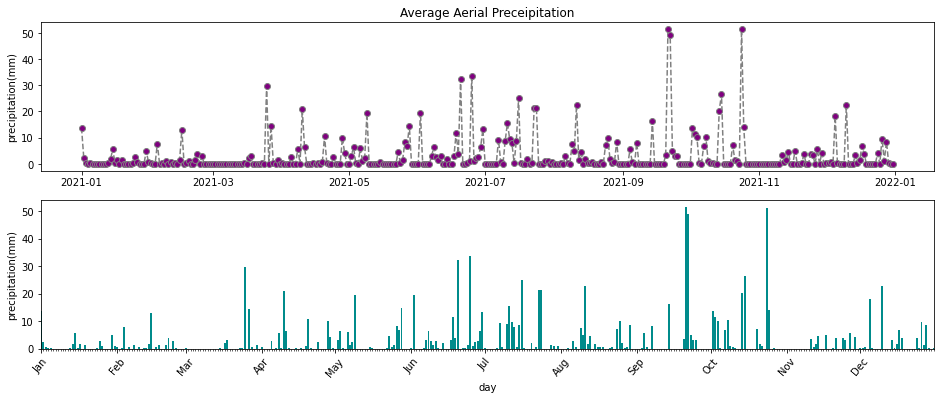

In [15]:
# Aerial average precipitation for the AOI (following the definition by NOAA)
precep_2021 = pr_data['precipitation_amount'].sel(lat=slice(aoi_lat[1], aoi_lat[0]),
                                                  lon=slice(aoi_lon[0], aoi_lon[1]))

# empty dict aerial average dict
day_ls = []
avg_ls = []
aerial_precep_df = pd.DataFrame()
for img in range(len(precep_2021)):
    #print(precep_2021['day'].values[img])
    day_ls.append(precep_2021['day'].values[img])
    daily_grid = precep_2021[img].values
    aerial_sum = np.sum(daily_grid)
    daily_aerial_average = aerial_sum /daily_grid.size
    avg_ls.append(daily_aerial_average)
    # fill up the dictionary with values key day: vale DAA
    
#print(aerial_avg_dict)

# dict to dataframe
aerial_precep_df['day'] = day_ls
aerial_precep_df['Aerial_Precipitation'] = avg_ls
print(aerial_precep_df.head())

# now plot the dataframe as TS line plot
fig, (ax1, ax2)  = plt.subplots(2,figsize=(16,6))
ax1.plot(aerial_precep_df.day,aerial_precep_df.Aerial_Precipitation,
        color='grey',
        linestyle='dashed',
        marker='o',
        markerfacecolor='purple')
ax1.set_title('Average Aerial Preceipitation')
#ax1.set_xlabel('day')
ax1.set_ylabel('precipitation(mm)')

# add bar plots in ax2 
ax2.bar(aerial_precep_df.day,
        aerial_precep_df.Aerial_Precipitation,
        color='darkcyan'
        )
ax2.set_xlabel('day')
ax2.set_ylabel('precipitation(mm)')
# month locator
month = mdates.MonthLocator()
# day locator
day = mdates.DayLocator()
# month format for display
monthFmt = mdates.DateFormatter('%b')
ax2.xaxis.set_major_locator(month)
ax2.xaxis.set_minor_locator(day)
# set display day formatter to the axis
ax2.xaxis.set_major_formatter(monthFmt)
# set limits
ax2.set_xlim(aerial_precep_df.day.min(),
             aerial_precep_df.day.max())
plt.xticks(rotation=50)
plt.show()
plt.close()

#### Gif movie creator 🎥
Use this cell to create a gif movie showing all image layers

In [16]:
# save pngs and create the gif for one year
# change the range for a leap year
for im in range(30):   #for im in range(len(precep_2021)):
        amount_arr = precep_2021[im].values
        #print(precep_2021[im].values.min())
        plt.imshow(amount_arr,
                   cmap=plt.cm.viridis,
                   interpolation='bilinear',
                   vmin=0,
                   vmax=30)
        # plot tittle
        plt.title('Date-'+str(precep_2021['day'].values[im])[:-19])
        # color bar
        clb = plt.colorbar(shrink=0.7,  pad=0.05)
        # color bar tittle
        clb.ax.set_title('mm')
        #levels = np.arange(0, 15, 0.5)
        #plt.contour(amount_arr, levels, colors='r', linewidths=0.2)
        plt.savefig('./output/png/'+str(precep_2021['day'].values[im])[:-19]+'.png',
                    dpi=200,
                    # trasparent=False
                   )
        
        #plt.show()
        plt.close()
        
# adding pngs here
png_list = glob.glob('./output/png/*')
# add sorting function if needed
png_set = sorted(png_list)
# empty image array declaration
gif_list= []
# append the array with each image
for png_files in png_set:
    gif_list.append(imageio.imread(png_files))
# change the speed adjesting the duration
imageio.mimwrite('./output/gif_image/animatedPrecep.gif', gif_list, duration=0.5)

### Creating a multiband tiff
Use follwing cell to create a multiband geotiff. It is handy if the package rasterio is your choice for raster data management.

In [17]:
# create a multiband geotiff
# Aerial average precipitation for the AOI (following the definition by NOAA)
prx = pr_data['precipitation_amount'].sel(lat=slice(aoi_lat[1], aoi_lat[0]),
                                                  lon=slice(aoi_lon[0], aoi_lon[1]))
prx = prx.rio.set_spatial_dims(x_dim='lon',
                               y_dim='lat')
# no need this step for current dataset as it already contains crs info
#prx.rio.crs
# define projection
#prx.rio.write_crs('epsg:4326', inplace=True)
prx.rio.to_raster(r'./output/multibandTiff/precep_2021.tiff')